In [3]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta as td
import pandas as pd
%matplotlib inline
import sys

#Make sure Python Analysis folder in in PYTHONPATH and import the MHDpy module
PythonAnalysisPath = 'C:\\Users\\aspit\\Git\\MHDLab\\Analysis\\Python Analysis'
if not PythonAnalysisPath in sys.path:
    sys.path.append(PythonAnalysisPath)
import MHDpy.importing
import MHDpy.plotting
import MHDpy.analysis
from nptdms import TdmsFile as TF

import importlib

mpl.rcParams.update({'font.size': 18})
    


In [5]:
###Paths###
pathnames_PL = MHDpy.importing.get_pathnames("C:\\Users\\aspit\\OneDrive\\Data\\2018-04-05 Power dependence\\Seqtry2", regExp= ".*\.tdms$")
pathnames_power = MHDpy.importing.get_pathnames("C:\\Users\\aspit\\OneDrive\\Data\\2018-04-05 Power dependence\\Powermeter\\Chosen\\50Hz", regExp= ".*\.tdms$")
pathnames_laser= MHDpy.importing.get_pathnames("C:\\Users\\aspit\\OneDrive\\Data\\LaserProfile")

###Files###

files_50Hz = pd.DataFrame(index = {'NDF00','NDF01','NDF02'}, columns = {'PL', 'Power'})

files_50Hz['PL']['NDF00'] = TF(pathnames_PL['Run15kV_Rb_NDF00_seq_50Hz_2000aq.tdms'])
files_50Hz['PL']['NDF01'] = TF(pathnames_PL['Run15kV_Rb_NDF01_seq_50Hz.tdms'])
files_50Hz['PL']['NDF02'] = TF(pathnames_PL['Run15kV_Rb_NDF02_seq_50Hz_7.tdms'])


files_50Hz['Power']['NDF00'] = TF(pathnames_power['Run15kV_Powermeter_NDF00_seq_50Hz_2000aq.tdms'])
files_50Hz['Power']['NDF01'] = TF(pathnames_power['Run15kV_Powermeter_NDF01_seq_50Hz.tdms'])
files_50Hz['Power']['NDF02'] = TF(pathnames_power['Run15kV_Powermeter_NDF02_seq_50Hz_7.tdms'])


file_laser = TF(pathnames_laser[0])

In [6]:
###Groups and Channels###

laser_common = file_laser.object('Raw').as_dataframe()
laser_data = file_laser.object('Average').as_dataframe()

laser_time = laser_common['Time1']
laser_data = laser_data['Mean']
laser_data_norm = laser_data/laser_data.max()

data_50Hz = pd.DataFrame(index = {'NDF00','NDF01','NDF02'},
                         columns = {'Data' , 'Time', 'Power','Power_avg','Data_p1_max', 'Data_p2_max', 'Data_p1_max_norm', 'Data_p2_max_norm'})


for index in files_50Hz.index:
    group = files_50Hz['PL'][index].object('Gate Delay Arrays').as_dataframe()
    data_50Hz['Time'][index] = group['GateDelay_1'].as_matrix()
    
    data_50Hz['Data'][index] = files_50Hz['PL'][index].object('Raw_1').as_dataframe()
    
    group = files_50Hz['Power'][index].object('Meter 1').as_dataframe()
    data_50Hz['Power'][index] = group['Power'].as_matrix()


offset_time = 870


wl = files_50Hz['PL']['NDF00'].object('Wavelength Array').as_dataframe()
wavelength = wl['Wavelength_1'].as_matrix()

laser_time_off = laser_time - offset_time


In [7]:
aq = 2000

#break up power wave and take average of sections

for index in data_50Hz['Power'].index:
    num_frames = len(data_50Hz['Data'][index].columns)
    data = data_50Hz['Power'][index]
    avg= np.zeros(num_frames)
    for i in range(0, num_frames):
        avg[i] =  np.average(data[i*aq:(i+1)*aq])
    #Power_norm[index] = avg
    data_50Hz['Power_avg'][index] = avg


In [8]:
importlib.reload(MHDpy.analysis)

#do peak average analysis and add it to the dataframe


for index in data_50Hz['Data'].index:
    data = data_50Hz['Data'][index]
    peak1_max, wl_peak1, data_cut_peak1 = MHDpy.analysis.PL_peakmax(data, wavelength, 778,780.5)
    peak2_max, wl_peak2, data_cut_peak2 = MHDpy.analysis.PL_peakmax(data, wavelength, 793,797)
    data_50Hz['Data_p1_max'][index] = peak1_max
    data_50Hz['Data_p2_max'][index] = peak2_max
    data_50Hz['Data_p1_max_norm'][index] = peak1_max/peak1_max.max()
    data_50Hz['Data_p2_max_norm'][index] = peak2_max/peak2_max.max()
    #NDF00_50Hz_data_p2_max_norm = NDF00_50Hz_data_p2_max/NDF00_50Hz_data_p2_max.max()

In [9]:
#Perform fits and add to the dataframe

fits_50Hz = pd.DataFrame(index = data_50Hz.index,
                         columns = { 'Fit_p1_param','Fit_p1', 'Fit_p1_time','Fit_p2_param', 'Fit_p2', 'Fit_p2_time'})

    
MHDpy.analysis.PL_fit_powerdep(data_50Hz,fits_50Hz,'NDF00',2,12)
MHDpy.analysis.PL_fit_powerdep(data_50Hz,fits_50Hz,'NDF01',2,7)
MHDpy.analysis.PL_fit_powerdep(data_50Hz,fits_50Hz,'NDF02',2,5)


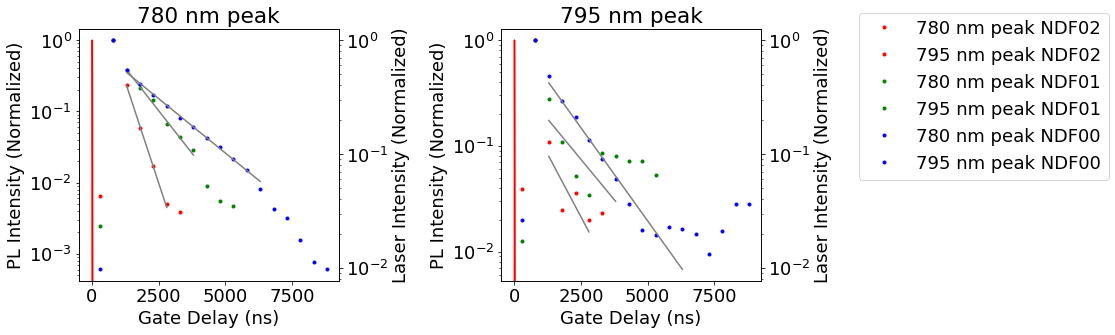

In [11]:
from matplotlib.ticker import ScalarFormatter


colors = ['r','g','b']

fig, ax1 = plt.subplots(1,2,figsize=(12,5))

lns = []


for i,index in enumerate(data_50Hz['Data'].index):
    ln = ax1[0].plot(data_50Hz['Time'][index], data_50Hz['Data_p1_max_norm'][index],'.', color = colors[i],  label = '780 nm peak '  + index)
    ax1[0].plot(fits_50Hz['Fit_p1_time'][index], fits_50Hz['Fit_p1'][index], '-', color = 'grey', label = '780 nm peak '  + index)

    lns = lns + ln
    
    ln = ax1[1].plot(data_50Hz['Time'][index], data_50Hz['Data_p2_max_norm'][index], '.', color = colors[i], label = '795 nm peak ' + index)
    ax1[1].plot(fits_50Hz['Fit_p2_time'][index], fits_50Hz['Fit_p2'][index], '-', color = 'grey', label = '780 nm peak ' + index)

    lns = lns + ln
    
for ax in ax1:
    ax.set_xlabel("Gate Delay (ns)")
    # Make the y-axis label, ticks and tick labels match the line color.
    ax.set_ylabel("PL Intensity (Normalized)")
    ax.tick_params('y')
    ax.loglog
    ax2 = ax.twinx()
    ln= ax2.plot(laser_time_off, laser_data_norm, 'r', label = 'Laser Intensity')  
    ax2.set_ylabel("Laser Intensity (Normalized)")
    ax2.tick_params('y')
    ax2.set_yscale('log')
    ax.set_yscale('log')

lns = lns# + ln7

ax1[0].set_title('780 nm peak')
ax1[1].set_title('795 nm peak')



fig.tight_layout()

labs = [l.get_label() for l in lns]
ax1[0].legend(lns, labs, loc=(3,0.4))

plt.show()



Text(0,0.5,'Peak Intensity (counts)')

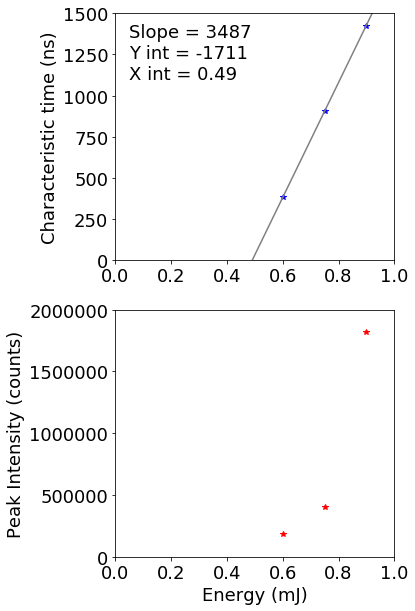

In [12]:
maximums = np.array([data_50Hz['Data_p1_max']['NDF00'].max(),data_50Hz['Data_p1_max']['NDF01'].max(),data_50Hz['Data_p1_max']['NDF02'].max()]) 

slopes = [-1/fits_50Hz['Fit_p1_param']['NDF00'][0],-1/fits_50Hz['Fit_p1_param']['NDF01'][0],-1/fits_50Hz['Fit_p1_param']['NDF02'][0]]

powers = [np.average(data_50Hz['Power_avg']['NDF00']),np.average(data_50Hz['Power_avg']['NDF01']),np.average(data_50Hz['Power_avg']['NDF02'])]
powers = np.array(powers)*1000



fit_char =np.polyfit(powers, slopes, 1)
fit_char_f =  np.poly1d(fit_char)

x_pow = np.linspace(0, 1, 100)


fig, ax = plt.subplots(2,1,figsize=(5,10))
ax[0].set_ylabel('Characteristic time (ns)')

ax[0].set_ylim([0,1500])
ax[0].set_xlim([0,1])
ax[0].plot(powers,slopes, 'b*')
ax[0].plot(x_pow, fit_char_f(x_pow), color = 'grey')

slopestr = "{:.{}f}".format( fit_char[0], 0 )
yintstr = "{:.{}f}".format( fit_char[1], 0 )
xintstr = "{:.{}f}".format(-fit_char[1]/fit_char[0], 2 )


ax[0].text(0.05,1100,'Slope = ' + slopestr + '\nY int = ' + yintstr + '\nX int = ' + xintstr)

ax[1].plot(powers, maximums,'r*')
#ax[1].set_yscale('log')
ax[1].set_xlabel('Energy (mJ)')
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,2e6])
ax[1].set_ylabel('Peak Intensity (counts)')

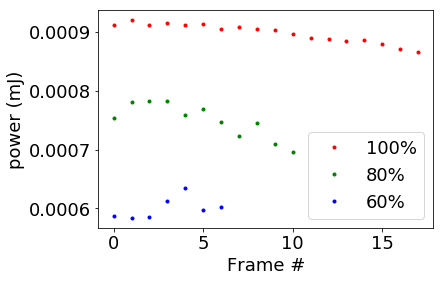

In [13]:
fig, ax1 = plt.subplots(1,1)

ln1 = ax1.plot(data_50Hz['Power_avg']['NDF00'], 'r.', label = '100%')
ln2 = ax1.plot(data_50Hz['Power_avg']['NDF01'], 'g.', label = '80%')
ln3 = ax1.plot(data_50Hz['Power_avg']['NDF02'], 'b.', label = '60%')

ax1.set_ylabel('power (mJ)')
ax1.set_xlabel('Frame #')
lns = ln1 + ln2 + ln3

labs = [l.get_label() for l in lns]
ax1.legend(lns, labs)
